CÓDIGO PARA DETERMINAR OS COEFICIENTES Tau PARA CALCULO DA TEMPERATURA EQUIVALENTE

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

Primeiramente, é feita a leitura de dados da ANEEL para determinar os coeficientes CP (COEF_SP) e Alfa (COEF_RE, COEF_IN, COEF_CO, COEF_RU, COEF_OU)

In [19]:
#Leitura dos Indicadores
filenameATRB = "Indicadores_ANEEL/Atributos.txt"

#Energia consumida residencial nos últimos 12 meses (ano móvel) MT e BT
CMMTRE = 156

#Energia consumida industrial nos últimos 12 meses (ano móvel) MT e BT
CMMTIN = 157 

#Energia consumida comercial nos últimos 12 meses (ano móvel) MT e BT
CMMTCO = 158

#Energia consumida rural nos últimos 12 meses (ano móvel) MT e BT Trimestral Atributos
CMMTRU = 159

#Energia consumida outras classes nos últimos 12 meses (ano móvel) MT e BT
CMMTOU = 160

data = pd.read_csv(filenameATRB, sep='\t',encoding = "ISO-8859-1")

#ENEL, ELEKTRO, EDP, SSE, CPFLpl, CPFLpr, CPFLsc
IdAgente = [390,385,391,5216,63,2937,69]

dados_cons = []
for k in IdAgente:
    E_RE = data[(data['IdAgente'] == k) & (data['PrdCptAnoInd'] == 2013) & (data['PrdCptInd'] == 4) & (data['IdeIdc'] == CMMTRE)].VlrInd.sum()
    E_IN = data[(data['IdAgente'] == k) & (data['PrdCptAnoInd'] == 2013) & (data['PrdCptInd'] == 4) & (data['IdeIdc'] == CMMTIN)].VlrInd.sum()
    E_CO = data[(data['IdAgente'] == k) & (data['PrdCptAnoInd'] == 2013) & (data['PrdCptInd'] == 4) & (data['IdeIdc'] == CMMTCO)].VlrInd.sum()
    E_RU = data[(data['IdAgente'] == k) & (data['PrdCptAnoInd'] == 2013) & (data['PrdCptInd'] == 4) & (data['IdeIdc'] == CMMTRU)].VlrInd.sum()
    E_OU = data[(data['IdAgente'] == k) & (data['PrdCptAnoInd'] == 2013) & (data['PrdCptInd'] == 4) & (data['IdeIdc'] == CMMTOU)].VlrInd.sum()
    E_TOT = E_RE + E_IN + E_CO + E_RU + E_OU
    COEF_RE = E_RE/E_TOT
    COEF_IN = E_IN/E_TOT
    COEF_CO = E_CO/E_TOT
    COEF_RU = E_RU/E_TOT
    COEF_OU = E_OU/E_TOT
    dados_cons.append([k,E_RE,E_IN,E_CO,E_RU,E_OU,E_TOT,COEF_RE,COEF_IN,COEF_CO,COEF_RU,COEF_OU])    
    
DATAC = pd.DataFrame(dados_cons,columns=['Dist','E_RE','E_IN','E_CO','E_RU','E_OU','E_TOT','COEF_RE','COEF_IN','COEF_CO','COEF_RU','COEF_OU'])
DATAC['COEF_SP'] = DATAC.E_TOT/DATAC.E_TOT.sum()

Leitura da base de dados do INMET e de CARGAS disponibilizado pelo ONS

In [20]:
INMET = pd.read_csv('Datathons_pec_carga/inmet.csv',sep=';')
CARGA = pd.read_csv('Datathons_pec_carga/seriesCargaSP.csv',sep=';',decimal=',')
MUN = pd.read_csv('Datathons_pec_carga/Municipios_SP.csv',sep=',')

INMET['datetime'] = pd.to_datetime(INMET['din_medicao'], infer_datetime_format = True, format="%Y-%M-%D %H:%M:%S")
CARGA['datetime1'] = pd.to_datetime(CARGA['din_ocorrencia'], infer_datetime_format = True, format="%Y-%M-%D %H:%M:%S")

Foi selecionada uma Estação de Medição de Temperatura para ser associada com cada uma das 7 distribuidoras de SP. Esta seleção foi feita de maneira visual considerando a proximidade da estação com o centro de carga

In [21]:
#ENEL
TEMP_ENEL = INMET[(INMET['id_varmeteo'] == 'TEM_INS') & (INMET['id_estacaometeo'] == 'A701')].sort_values(by=['datetime']).reset_index().drop(columns=['index','val_latitude','val_longitude','din_medicao','val_altitude','id_varmeteo','din_inclusaodl','nom_longo','id_estacaometeo','nom_varmeteo'])
CARGA_ENEL = CARGA[CARGA['nom_seriehistorica'] == 'SP-ELETROPAULO'].sort_values(by=['datetime1']).reset_index().drop(columns=['index','din_ocorrencia'])
ENEL = pd.concat([TEMP_ENEL,CARGA_ENEL],axis=1).drop(columns=['datetime1'])

#ELEKTRO
TEMP_ELEKTRO = INMET[(INMET['id_varmeteo'] == 'TEM_INS') & (INMET['id_estacaometeo'] == 'A729')].sort_values(by=['datetime']).reset_index().drop(columns=['index','val_latitude','val_longitude','din_medicao','val_altitude','id_varmeteo','din_inclusaodl','nom_longo','id_estacaometeo','nom_varmeteo'])
CARGA_ELEKTRO = CARGA[CARGA['nom_seriehistorica'] == 'SP-ELEKTRO'].sort_values(by=['datetime1']).reset_index().drop(columns=['index','din_ocorrencia'])
ELEKTRO = pd.concat([TEMP_ELEKTRO,CARGA_ELEKTRO],axis=1).drop(columns=['datetime1'])

#EDP
TEMP_EDP = INMET[(INMET['id_varmeteo'] == 'TEM_INS') & (INMET['id_estacaometeo'] == 'A728')].sort_values(by=['datetime']).reset_index().drop(columns=['index','val_latitude','val_longitude','din_medicao','val_altitude','id_varmeteo','din_inclusaodl','nom_longo','id_estacaometeo','nom_varmeteo'])
CARGA_EDP = CARGA[CARGA['nom_seriehistorica'] == 'SP-EDP SP'].sort_values(by=['datetime1']).reset_index().drop(columns=['index','din_ocorrencia'])
EDP = pd.concat([TEMP_EDP,CARGA_EDP],axis=1).drop(columns=['datetime1'])

#SSE
TEMP_SSE = INMET[(INMET['id_varmeteo'] == 'TEM_INS') & (INMET['id_estacaometeo'] == 'A707')].sort_values(by=['datetime']).reset_index().drop(columns=['index','val_latitude','val_longitude','din_medicao','val_altitude','id_varmeteo','din_inclusaodl','nom_longo','id_estacaometeo','nom_varmeteo'])
CARGA_SSE = CARGA[CARGA['nom_seriehistorica'] == 'SP-ENERGISA SSE-SP'].sort_values(by=['datetime1']).reset_index().drop(columns=['index','din_ocorrencia'])
SSE = pd.concat([TEMP_SSE,CARGA_SSE],axis=1).drop(columns=['datetime1'])

#CPFL paulista
TEMP_CPFLpl = INMET[(INMET['id_varmeteo'] == 'TEM_INS') & (INMET['id_estacaometeo'] == 'A737')].sort_values(by=['datetime']).reset_index().drop(columns=['index','val_latitude','val_longitude','din_medicao','val_altitude','id_varmeteo','din_inclusaodl','nom_longo','id_estacaometeo','nom_varmeteo'])
CARGA_CPFLpl = CARGA[CARGA['nom_seriehistorica'] == 'SP-CPFL PAULISTA'].sort_values(by=['datetime1']).reset_index().drop(columns=['index','din_ocorrencia'])
CPFLpl = pd.concat([TEMP_CPFLpl,CARGA_CPFLpl],axis=1).drop(columns=['datetime1'])

#CPFL piratininga
TEMP_CPFLpr = INMET[(INMET['id_varmeteo'] == 'TEM_INS') & (INMET['id_estacaometeo'] == 'A713')].sort_values(by=['datetime']).reset_index().drop(columns=['index','val_latitude','val_longitude','din_medicao','val_altitude','id_varmeteo','din_inclusaodl','nom_longo','id_estacaometeo','nom_varmeteo'])
CARGA_CPFLpr = CARGA[CARGA['nom_seriehistorica'] == 'SP-CPFL PIRATININGA'].sort_values(by=['datetime1']).reset_index().drop(columns=['index','din_ocorrencia'])
CPFLpr = pd.concat([TEMP_CPFLpr,CARGA_CPFLpr],axis=1).drop(columns=['datetime1'])

#CPFL santa cruz
TEMP_CPFLsc = INMET[(INMET['id_varmeteo'] == 'TEM_INS') & (INMET['id_estacaometeo'] == 'A725')].sort_values(by=['datetime']).reset_index().drop(columns=['index','val_latitude','val_longitude','din_medicao','val_altitude','id_varmeteo','din_inclusaodl','nom_longo','id_estacaometeo','nom_varmeteo'])
CARGA_CPFLsc = CARGA[CARGA['nom_seriehistorica'] == 'SP-CPFL SANTA CRUZ'].sort_values(by=['datetime1']).reset_index().drop(columns=['index','din_ocorrencia'])
CPFLsc = pd.concat([TEMP_CPFLsc,CARGA_CPFLsc],axis=1).drop(columns=['datetime1'])


Plotar os dados de carga e temperatura para cada distribuidora

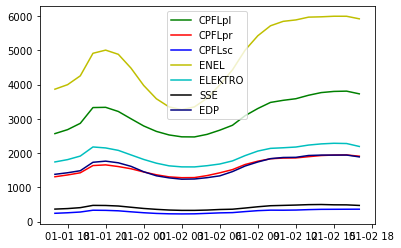

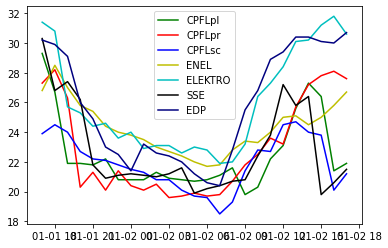

In [22]:
#PLOTAR OS DADOS
d1 = '2018-01-01 17:00:00'
d2 = '2018-01-02 17:00:00'
filtroEDP = (EDP['datetime'] >= d1) & (EDP['datetime'] <= d2)
filtroENEL = (ENEL['datetime'] >= d1) & (ENEL['datetime'] <= d2)
filtroELEKTRO = (ELEKTRO['datetime'] >= d1) & (ELEKTRO['datetime'] <= d2)
filtroSSE = (SSE['datetime'] >= d1) & (SSE['datetime'] <= d2)
filtroCPFLpl = (CPFLpl['datetime'] >= d1) & (CPFLpl['datetime'] <= d2)
filtroCPFLpr = (CPFLpr['datetime'] >= d1) & (CPFLpr['datetime'] <= d2)
filtroCPFLsc = (CPFLsc['datetime'] >= d1) & (CPFLsc['datetime'] <= d2)

# Plot a simple line chart
plt.plot(CPFLpl[filtroCPFLpl].datetime, CPFLpl[filtroCPFLpl].val_itemserieoriginal, color='g', label='CPFLpl')
plt.plot(CPFLpr[filtroCPFLpr].datetime, CPFLpr[filtroCPFLpr].val_itemserieoriginal, color='r', label='CPFLpr')
plt.plot(CPFLsc[filtroCPFLsc].datetime, CPFLsc[filtroCPFLsc].val_itemserieoriginal, color='b', label='CPFLsc')
plt.plot(ENEL[filtroENEL].datetime, ENEL[filtroENEL].val_itemserieoriginal, color='y', label='ENEL')
plt.plot(ELEKTRO[filtroELEKTRO].datetime, ELEKTRO[filtroELEKTRO].val_itemserieoriginal, color='c', label='ELEKTRO')
plt.plot(SSE[filtroSSE].datetime, SSE[filtroSSE].val_itemserieoriginal, color='k', label='SSE')
plt.plot(EDP[filtroEDP].datetime, EDP[filtroEDP].val_itemserieoriginal, color='navy', label='EDP')


plt.legend()
plt.show()

# Plot a simple line chart
plt.plot(CPFLpl[filtroCPFLpl].datetime, CPFLpl[filtroCPFLpl].val_medicao, color='g', label='CPFLpl')
plt.plot(CPFLpr[filtroCPFLpr].datetime, CPFLpr[filtroCPFLpr].val_medicao, color='r', label='CPFLpr')
plt.plot(CPFLsc[filtroCPFLsc].datetime, CPFLsc[filtroCPFLsc].val_medicao, color='b', label='CPFLsc')
plt.plot(ENEL[filtroENEL].datetime, ENEL[filtroENEL].val_medicao, color='y', label='ENEL')
plt.plot(ELEKTRO[filtroELEKTRO].datetime, ELEKTRO[filtroELEKTRO].val_medicao, color='c', label='ELEKTRO')
plt.plot(SSE[filtroSSE].datetime, SSE[filtroSSE].val_medicao, color='k', label='SSE')
plt.plot(EDP[filtroEDP].datetime, EDP[filtroEDP].val_medicao, color='navy', label='EDP')

plt.legend()
plt.show()

Determinar as Matrizes M1 e M2 com base nos coeficientes previamente calculados e nas medições de temperatura de cada estação associada. Plotar o resultado para verificar intervalos válidos.

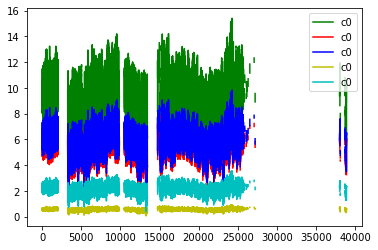

In [23]:
M1 = np.array([list(TEMP_ENEL.val_medicao*DATAC.COEF_SP.iloc[0]),list(TEMP_ELEKTRO.val_medicao*DATAC.COEF_SP.iloc[1]),list(TEMP_EDP.val_medicao*DATAC.COEF_SP.iloc[2]),
     list(TEMP_SSE.val_medicao*DATAC.COEF_SP.iloc[3]),list(TEMP_CPFLpl.val_medicao*DATAC.COEF_SP.iloc[4]),list(TEMP_CPFLpr.val_medicao*DATAC.COEF_SP.iloc[5]),
     list(TEMP_CPFLsc.val_medicao*DATAC.COEF_SP.iloc[6])]).T

M2 = np.array([list(DATAC.COEF_RE),list(DATAC.COEF_IN),list(DATAC.COEF_CO),list(DATAC.COEF_RU),list(DATAC.COEF_OU)]).T

M0 = np.matmul(M1, M2)

Mref = pd.DataFrame(M0)

plt.plot(list(Mref.index), Mref[0], color='g', label='c0')
plt.plot(list(Mref.index), Mref[1], color='r', label='c0')
plt.plot(list(Mref.index), Mref[2], color='b', label='c0')
plt.plot(list(Mref.index), Mref[3], color='y', label='c0')
plt.plot(list(Mref.index), Mref[4], color='c', label='c0')
plt.legend()
plt.show()

Pre selecionar os dados que serão utilizados para treino e teste

In [24]:
#Limitar
a = Mref[0].values  # Extract out relevant column from dataframe as array
m = np.concatenate(( [True], np.isnan(a), [True] ))  # Mask
ss = np.flatnonzero(m[1:] != m[:-1]).reshape(-1,2)   # Start-stop limits
start,stop = ss[(ss[:,1] - ss[:,0]).argmax()]  # Get max interval, interval limits

d0 = start
d1 = stop

#d0 = 20000
#d1 = 21000

Mref_cut = Mref[d0:d1]

Ctot = ELEKTRO.val_itemserieoriginal+ENEL.val_itemserieoriginal+SSE.val_itemserieoriginal+EDP.val_itemserieoriginal+CPFLpl.val_itemserieoriginal+CPFLpr.val_itemserieoriginal+CPFLsc.val_itemserieoriginal
Ctot_cut = Ctot[d0:d1]

Realizar regressao linear para obter os coeficientes Tau. Avaliar o coeficiente de determinação.

In [25]:
#Separando os dados de Treino e Teste
impx = SimpleImputer(missing_values=np.nan, strategy='mean') 
impx = impx.fit(Mref_cut)
Mref_cut_imp = impx.transform(Mref_cut)

impy = SimpleImputer(missing_values=np.nan, strategy='mean') 
impy = impy.fit(np.array(Ctot_cut).reshape(-1,1))
Ctot_cut_imp = impy.transform(np.array(Ctot_cut).reshape(-1,1))

x_train, x_test, y_train, y_test = train_test_split(Mref_cut_imp, Ctot_cut_imp, test_size=0.2, random_state=0)

#Criando um Objeto de Regressão Linear
lr = LinearRegression()

#Treinando o Modelo
lr.fit(x_train,y_train)

#Verificando o resultado
r_sq = lr.score(Mref_cut_imp, Ctot_cut_imp)
print('Coeficiente de Determinação (R²):', r_sq)

Coeficiente de Determinação (R²): 0.41059435342473394
